<a href="https://colab.research.google.com/github/luquelab/lab-bioinformatics-workshops/blob/main/protein_language_models/viral_PLMs_functional_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Install Required Packages
!pip install umap-learn

## Importing libraries

In this step, we import all the tools we will need for our analysis. Each library serves a purpose. Libraries `pickle` and `scikit-learn` are popular toolkits for embeddings and machine learning analyses.


In [2]:
# Step 2: Import Libraries
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE, MDS
from sklearn.metrics.pairwise import euclidean_distances
from umap import UMAP
from typing import List, Dict
from google.colab import files
import io

## Upload Required Files

Here we upload a **CSV file** that lists the functional categories predicted by our VPF-PLM classifier (*Flamholz et al. 2019*). The function load_color_scheme builds a dictionary so each category always appears in the same color.

![Protein classifier schematic](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41564-023-01584-8/MediaObjects/41564_2023_1584_Fig1_HTML.png?as=webp)

---

- A classifier is a machine learning model that assigns inputs to predefined categories.  
- We use predictions from **VPF-PLM**, a protein language model trained on viral protein families and profiles.  
  - Amino acids → letters  
  - Protein sequences → sentences  
  - Embeddings → numerical vectors capturing meaning  
- VPF-PLM outputs broad **functional classifications** for viral proteins, even when no close homologs exist.




In [3]:
# Step 3: Upload Required Files
print("Upload the CSV file containing the plm_categories")
uploaded = files.upload()
color_file = list(uploaded.keys())[0]
color_df = pd.read_csv(io.BytesIO(uploaded[color_file]))

def load_color_scheme(color_df) -> Dict[str, str]:
    return {row['Category'].strip().lower(): row['Color'] for _, row in color_df.iterrows()}

color_scheme = load_color_scheme(color_df)

Upload the CSV file containing the plm_categories


Saving plm_categories.csv to plm_categories (3).csv


In [4]:
import zipfile
import tempfile   # ← add this

print("Upload a ZIP file containing all genome folders (with embeddings and predictions).")
uploaded_zip = files.upload()

zip_file = list(uploaded_zip.keys())[0]
temp_dir = tempfile.mkdtemp()
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

print(f"Extracted data to: {temp_dir}")


Upload a ZIP file containing all genome folders (with embeddings and predictions).


Saving data_subset.zip to data_subset (4).zip
Extracted data to: /tmp/tmpfbshacpp


## Pickle files

Here we upload a ZIP file containing the results of protein language model (PLM) runs for each viral genome. When unzipped, each genome has its own folder (e.g., `DTR_817724.faa.plm/`) with several files, including `pickle` files containing the embeddings for each genome.

- `*_embeddings_dict.pkl` → a **pickled Python dictionary** storing protein embeddings. These embeddings are vectors (long lists of numbers that describe each protein in a high-dimensional space). This is the “numerical language” the PLM has learned, similar to how word embeddings capture meaning in human languages. Later in the code, we will load these with `pickle` and treat them as arrays (`numpy`), so we can measure distances and similarities.

 At this point, we have everything organized and ready: embeddings (as vectors), predictions (as tables), and raw sequences. From here, the rest of the workflow will let us explore how proteins relate to each other when placed into a multidimensional space defined by the PLM.


In [5]:
# Step 5: Load Embeddings and Predictions (robust to extra wrapper folders, macOS junk)
from pathlib import Path

def find_genome_dirs(root_dir: str):
    """Walk root_dir and yield directories that contain the expected files."""
    required_pkl = "_embeddings_dict.pkl"
    required_csv = "_function_predictions.csv"
    for curr, dirs, files in os.walk(root_dir):
        # ignore macOS resource forks and hidden dirs
        base = os.path.basename(curr)
        if base.startswith('.') or base == '__MACOSX':
            continue
        # normalize file list without resource forks
        clean = [f for f in files if not f.startswith('._')]
        if any(f.endswith(required_pkl) for f in clean) and any(f.endswith(required_csv) for f in clean):
            yield curr


def load_data_from_directory(root_dir):
    genome_embeddings = {}
    functional_predictions = {}

    genome_dirs = list(find_genome_dirs(root_dir))
    if not genome_dirs:
        # try one level deeper if a single wrapper folder exists (e.g., data_subset/)
        subdirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir)
                   if os.path.isdir(os.path.join(root_dir, d)) and not d.startswith('.') and d != '__MACOSX']
        if len(subdirs) == 1:
            genome_dirs = list(find_genome_dirs(subdirs[0]))

    if not genome_dirs:
        print(f"No genome directories found under {root_dir}. Check your ZIP structure.")
        return genome_embeddings, functional_predictions

    for gdir in genome_dirs:
        genome_folder = os.path.basename(gdir)
        files_here = [f for f in os.listdir(gdir) if not f.startswith('._')]
        # pick the first matching file per type (or prefer the longest name)
        pkl_candidates = sorted([f for f in files_here if f.endswith('_embeddings_dict.pkl')], key=len, reverse=True)
        csv_candidates = sorted([f for f in files_here if f.endswith('_function_predictions.csv')], key=len, reverse=True)
        if pkl_candidates:
            with open(os.path.join(gdir, pkl_candidates[0]), 'rb') as f:
                genome_embeddings[genome_folder] = pickle.load(f)
        if csv_candidates:
            functional_predictions[genome_folder] = pd.read_csv(os.path.join(gdir, csv_candidates[0]))

    print(f"Loaded embeddings and predictions for {len(genome_embeddings)} genomes.")
    # brief sanity log
    if genome_embeddings:
        eg = next(iter(genome_embeddings.keys()))
        print(f"Example genome: {eg} → {len(genome_embeddings[eg])} proteins,"
              f" predictions shape {functional_predictions[eg].shape if eg in functional_predictions else 'N/A'}")
    return genome_embeddings, functional_predictions

# Optional: show a compact tree to confirm layout
print("Top level:", temp_dir)
for root, dirs, files in list(os.walk(temp_dir))[:40]:
    level = root.replace(temp_dir, '').count(os.sep)
    indent = '  ' * level
    base = os.path.basename(root) or root
    print(f"{indent}{base}/")
    for f in files[:6]:
        if not f.startswith('._'):
            print(f"{indent}  - {f}")

# Load now
genome_embeddings, functional_predictions = load_data_from_directory(temp_dir)




Top level: /tmp/tmpfbshacpp
tmpfbshacpp/
  data_subset/
    - .DS_Store
    DTR_648837.faa.plm/
      - DTR_648837_function_predictions.csv
      - DTR_648837_functional_probabilities.csv
      - DTR_648837_embeddings_dict.pkl
      - prediction_heatmap.png
      - DTR_648837.faa
    DTR_765588.faa.plm/
      - prediction_heatmap.png
      - DTR_765588_functional_probabilities.csv
      - DTR_765588_function_predictions.csv
      - DTR_765588.faa
      - DTR_765588_embeddings_dict.pkl
    DTR_354565.faa.plm/
      - DTR_354565_embeddings_dict.pkl
      - DTR_354565.faa
      - prediction_heatmap.png
      - DTR_354565_functional_probabilities.csv
      - DTR_354565_function_predictions.csv
    DTR_534463.faa.plm/
      - DTR_534463_function_predictions.csv
      - prediction_heatmap.png
      - DTR_534463.faa
      - DTR_534463_functional_probabilities.csv
      - DTR_534463_embeddings_dict.pkl
    DTR_022117.faa.plm/
      - DTR_022117_embeddings_dict.pkl
      - prediction_heatmap.pn

## Filter Out 'Unknown' Proteins

Not all proteins get a confident classification from the model—some end up as “unknown.”

Here we filter those out so that downstream analyses focus only on proteins with an assigned functional category. Practically, this means we keep only the rows in the CSVs (and the matching embeddings) where the classifier provided a meaningful label.


In [6]:
# Step 6: Filter Out 'Unknown' Proteins
filtered_embeddings = {}
filtered_predictions = {}
for genome, predictions in functional_predictions.items():
  filtered_preds = predictions[predictions['class_phrog'].str.strip().str.lower() != 'unknown']
  filtered_predictions[genome] = filtered_preds
  filtered_protein_ids = set(filtered_preds['protein_id'])
  filtered_embeds = {pid: emb for pid, emb in genome_embeddings[genome].items() if pid in filtered_protein_ids}
  filtered_embeddings[genome] = filtered_embeds

## Assign Functional Classes to Genomes

Each genome can contain many proteins, but to simplify comparisons we assign it a single functional label (the most common class among its proteins). This gives us a quick way to summarize what each genome is mostly “about.”


In [7]:
# Step 7: Assign Functional Classes to Genomes
def assign_most_prevalent_functional_class(predictions_dict):
  genome_functional_categories = {}
  for genome, predictions in predictions_dict.items():
    class_counts = predictions['class_phrog'].str.strip().str.lower().value_counts()
    class_counts = class_counts.drop('unknown', errors='ignore')
    most_prevalent_class = class_counts.idxmax() if not class_counts.empty else 'unknown'
    genome_functional_categories[genome] = most_prevalent_class
  return genome_functional_categories


## Distance Threshold for Clustering

When clustering embeddings, we need to decide **how close two proteins must be** in multidimensional space to be grouped together. This cutoff is the **distance threshold**:  
- If the threshold is small, only very similar proteins will cluster.  
- If it is large, broader and more diverse groups will form.

Here we let the user type a value, but we also set a **default of 2.0**. This number is not final.


In [8]:
# Step 8: Prompt for Distance Threshold
try:
  distance_threshold = float(input("Enter clustering distance threshold (default=2.0): "))
except:
  distance_threshold = 2.0
  print(f"Using threshold: {distance_threshold}")

Enter clustering distance threshold (default=2.0): 2


## Step 9: Clustering, labeling, and visualizing homolog groups

This section turns **protein embeddings** into **homologous clusters**, assigns each cluster a **putative function**, and shows the result.

---

### 1) `assign_functional_classes_to_clusters`
**What it does:** gives each cluster a single functional label.

**How it works (stage-by-stage):**
1. **Inputs:**  
   - `labels`: cluster ID for every protein (one label per embedding).  
   - `protein_to_genome_map`: pairs `(genome, protein_id)` aligned with `labels`.  
   - `predictions_dict`: per-genome tables with `protein_id`, `class_phrog`, and `phrog_model_score`.
2. **Aggregate evidence:** for each cluster, collect all proteins in it and the classifier’s **scores** for their predicted classes.
3. **Score pooling:** average the `phrog_model_score` for each functional class **within the cluster**.
4. **Choose a winner:** assign the class with the **highest average score** as the cluster’s label.  
   *Rationale:* if a cluster is biologically coherent, its members should support the same functional class with consistently high scores.

---

### 2) `plot_cluster_size_histogram`
**What it does:** shows the distribution of **cluster sizes**.

**Why it matters:**  
- Very small clusters may be noise or rare families.  
- Very large clusters may indicate broad, conserved functions (or over-merging if the distance threshold is high).  
This is a quick sanity check for our clustering granularity.

---

### 3) `visualize_homolog_clusters`
**What it does:** reduces high-dimensional embeddings to **2D/3D** and plots them, coloring points by the cluster’s assigned functional class.

- **Dimensionality reduction:**  
  - **UMAP / t-SNE / MDS** turn thousands of features into 2–3 coordinates while preserving neighborhood structure (UMAP/t-SNE emphasize local neighborhoods; MDS preserves global distances more directly).  
- **Color mapping:** the cluster label is mapped to a color via `color_scheme`.

This step gives an **intuitive map** of which proteins group together in the embedding space.

---

### 4) `cluster_embeddings`
**What it does:** performs the actual **clustering** of protein embeddings and triggers labeling + visualization.

 - **Collect embeddings:** stack all protein vectors into a single matrix (`all_embeddings`) and keep an aligned `protein_map` to remember who is who.
 - **Agglomerative clustering:**  
   - Uses **hierarchical (bottom-up)** merging: start with each protein as its own cluster and **merge the closest pairs** until inter-cluster distances exceed `distance_threshold`.  
   - `n_clusters=None` + `distance_threshold=...` means the **distance cutoff** controls where we stop merging (granularity).  
   - Assumption: embeddings close in this space are likely homologous or functionally similar.
 - **Assign cluster functions:** call `assign_functional_classes_to_clusters(...)` to label each cluster using classifier scores.
 - **Quality check + view:**  
   - `plot_cluster_size_histogram` to inspect cluster sizes,  
   - `visualize_homolog_clusters` to see the embedding layout in 2D/3D with functional colors.

`distance_threshold`: smaller values create **more, tighter clusters**; larger values create **fewer, broader clusters**.


In [ ]:
# --- 3D interactive cluster visualization (Plotly), keeping your color scheme ---
!pip install -q plotly

import numpy as np
import plotly.graph_objects as go
from sklearn.manifold import MDS, TSNE
from umap import UMAP
from sklearn.metrics import pairwise_distances

# Step 9: Helper Functions for Clustering and Visualization
def assign_functional_classes_to_clusters(labels, protein_to_genome_map, predictions_dict):
    cluster_scores = {}
    cluster_functional_classes = {}
    for idx, (genome, protein_id) in enumerate(protein_to_genome_map):
        cluster_id = labels[idx]
        protein_data = predictions_dict[genome][predictions_dict[genome]['protein_id'] == protein_id]
        if not protein_data.empty:
            fc = protein_data['class_phrog'].values[0].strip().lower()
            score = protein_data['phrog_model_score'].values[0]
            cluster_scores.setdefault(cluster_id, {}).setdefault(fc, []).append(score)
    for cluster_id, scores in cluster_scores.items():
        avg_scores = {fc: np.mean(scores_list) for fc, scores_list in scores.items()}
        cluster_functional_classes[cluster_id] = max(avg_scores, key=avg_scores.get)
    return cluster_functional_classes

def plot_cluster_size_histogram(labels):
    sizes = pd.Series(labels).value_counts()
    plt.figure(figsize=(8, 6))
    plt.hist(sizes.values, bins=range(1, sizes.max() + 2), color='skyblue', edgecolor='black')
    plt.xlabel('Cluster Size')
    plt.ylabel('Frequency')
    plt.title('Cluster Size Histogram')
    plt.show()

def visualize_homolog_clusters(embeddings, labels, cluster_functional_classes, color_scheme, method='UMAP', n_components=3):
    reducer = {'UMAP': UMAP, 'TSNE': TSNE, 'MDS': MDS}.get(method, UMAP)(n_components=n_components)
    reduced = reducer.fit_transform(embeddings)
    colors = [color_scheme.get(cluster_functional_classes.get(l, 'unknown'), '#d3d3d3') for l in labels]
    filtered = [(x, c) for x, c in zip(reduced, colors) if c != '#d3d3d3']
    if not filtered:
        print("No valid clusters to display.")
        return
    X, C = zip(*filtered)
    X = np.array(X)
    if n_components == 3:
        ax = plt.figure().add_subplot(111, projection='3d')
        ax.scatter(X[:,0], X[:,1], X[:,2], c=C, alpha=0.7)
    else:
        plt.scatter(X[:,0], X[:,1], c=C, alpha=0.7)
    plt.title("Homologous Clusters (Filtered)")
    plt.show()

def cluster_embeddings(embeddings_dict, predictions_dict, distance_threshold):
    all_embeddings, protein_map = [], []
    for genome, prot_dict in embeddings_dict.items():
        for pid, emb in prot_dict.items():
            all_embeddings.append(emb)
            protein_map.append((genome, pid))
    all_embeddings = np.vstack(all_embeddings)
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=distance_threshold)
    labels = clustering.fit_predict(all_embeddings)
    cluster_functional_classes = assign_functional_classes_to_clusters(labels, protein_map, predictions_dict)
    plot_cluster_size_histogram(labels)
    visualize_homolog_clusters(all_embeddings, labels, cluster_functional_classes, color_scheme)
    return labels, cluster_functional_classes

def visualize_homolog_clusters_3d_plotly(
    embeddings: np.ndarray,
    labels: np.ndarray,
    cluster_functional_classes: dict,
    color_scheme: dict,
    protein_to_genome_map: list,   # [(genome, protein_id), ...] aligned with embeddings/labels
    method: str = 'UMAP',
    title: str = "Homologous Proteins in Embedding Space (3D)"
):
    """
    Interactive 3D scatter of protein embeddings colored by cluster functional class.
    - Preserves your color scheme.
    - Shows hover info (protein_id, genome, cluster_id, class).
    - Filters out 'unknown' (kept gray in mapping) to match your current behavior.
    """
    method = method.upper()
    if method == 'UMAP':
        reducer = UMAP(n_components=3, metric='cosine', random_state=42)
        coords = reducer.fit_transform(embeddings)
    elif method == 'TSNE':
        # Use precomputed distances for non-euclidean-friendly behavior
        D = pairwise_distances(embeddings, metric='cosine')
        coords = TSNE(
            n_components=3, metric='precomputed',
            init='random', learning_rate='auto', random_state=42
        ).fit_transform(D)
    elif method == 'MDS':
        D = pairwise_distances(embeddings, metric='cosine')
        coords = MDS(n_components=3, dissimilarity='precomputed', random_state=42).fit_transform(D)
    else:
        raise ValueError("method must be one of: 'UMAP', 'TSNE', 'MDS'")

    # Map each protein (point) to its cluster functional class and color
    classes = []
    colors  = []
    cluster_ids = []
    for i, lab in enumerate(labels):
        fc = cluster_functional_classes.get(lab, 'unknown')
        classes.append(fc)
        colors.append(color_scheme.get(fc, '#d3d3d3'))  # gray for unknown
        cluster_ids.append(lab)

    # Filter out unknowns (gray) like your matplotlib version
    keep_idx = [i for i, c in enumerate(colors) if c != '#d3d3d3']
    if not keep_idx:
        print("No valid clusters to display (non-unknown).")
        return

    coords = coords[keep_idx]
    classes = [classes[i] for i in keep_idx]
    colors  = [colors[i]  for i in keep_idx]
    cluster_ids = [cluster_ids[i] for i in keep_idx]
    kept_p2g = [protein_to_genome_map[i] for i in keep_idx]

    # Build one trace per functional class -> preserves legend labels and colors
    class_to_indices = {}
    for i, fc in enumerate(classes):
        class_to_indices.setdefault(fc, []).append(i)

    traces = []
    for fc, idxs in class_to_indices.items():
        xyz = coords[idxs]
        # Hover: protein_id, genome, cluster_id, class
        hover_text = [
            f"protein: {kept_p2g[i][1]}<br>genome: {kept_p2g[i][0]}<br>cluster: {cluster_ids[i]}<br>class: {fc}"
            for i in idxs
        ]
        traces.append(
            go.Scatter3d(
                x=xyz[:,0], y=xyz[:,1], z=xyz[:,2],
                mode="markers",
                marker=dict(size=4, opacity=0.85, color=color_scheme.get(fc, '#808080')),
                name=fc,
                text=hover_text,
                hovertemplate="%{text}<extra></extra>"
            )
        )

    fig = go.Figure(data=traces)
    fig.update_layout(
        title=title,
        scene=dict(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False),
        legend=dict(itemsizing='trace', bgcolor='rgba(255,255,255,0.6)'),
        margin=dict(l=0, r=0, t=40, b=0),
        height=650
    )
    fig.show()

def cluster_embeddings(embeddings_dict, predictions_dict, distance_threshold, method='UMAP'):
    all_embeddings, protein_map = [], []
    for genome, prot_dict in embeddings_dict.items():
        for pid, emb in prot_dict.items():
            all_embeddings.append(emb)
            protein_map.append((genome, pid))
    all_embeddings = np.vstack(all_embeddings)

    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=distance_threshold)
    labels = clustering.fit_predict(all_embeddings)

    cluster_functional_classes = assign_functional_classes_to_clusters(labels, protein_map, predictions_dict)

    # 3D interactive plot (replaces the old matplotlib scatter)
    visualize_homolog_clusters_3d_plotly(
        embeddings=all_embeddings,
        labels=labels,
        cluster_functional_classes=cluster_functional_classes,
        color_scheme=color_scheme,
        protein_to_genome_map=protein_map,
        method=method,
        title=f"Homologous Proteins (3D {method})"
    )
    return labels, cluster_functional_classes

    print("\nRunning clustering on filtered dataset...")
labels, cluster_classes = cluster_embeddings(filtered_embeddings, filtered_predictions, distance_threshold)


In [11]:
def assign_functional_classes_to_clusters(labels, protein_to_genome_map, predictions_dict):
    cluster_scores = {}
    cluster_functional_classes = {}
    for idx, (genome, protein_id) in enumerate(protein_to_genome_map):
        cluster_id = labels[idx]
        protein_data = predictions_dict[genome][predictions_dict[genome]['protein_id'] == protein_id]
        if not protein_data.empty:
            fc = protein_data['class_phrog'].values[0].strip().lower()
            score = protein_data['phrog_model_score'].values[0]
            cluster_scores.setdefault(cluster_id, {}).setdefault(fc, []).append(score)
    for cluster_id, scores in cluster_scores.items():
        avg_scores = {fc: np.mean(scores_list) for fc, scores_list in scores.items()}
        cluster_functional_classes[cluster_id] = max(avg_scores, key=avg_scores.get)
    return cluster_functional_classes

def plot_cluster_size_histogram(labels):
    sizes = pd.Series(labels).value_counts()
    plt.figure(figsize=(8, 6))
    plt.hist(sizes.values, bins=range(1, sizes.max() + 2), color='skyblue', edgecolor='black')
    plt.xlabel('Cluster Size')
    plt.ylabel('Frequency')
    plt.title('Cluster Size Histogram')
    plt.show()

def visualize_homolog_clusters(embeddings, labels, cluster_functional_classes, color_scheme, method='UMAP', n_components=3):
    reducer = {'UMAP': UMAP, 'TSNE': TSNE, 'MDS': MDS}.get(method, UMAP)(n_components=n_components)
    reduced = reducer.fit_transform(embeddings)
    colors = [color_scheme.get(cluster_functional_classes.get(l, 'unknown'), '#d3d3d3') for l in labels]
    filtered = [(x, c) for x, c in zip(reduced, colors) if c != '#d3d3d3']
    if not filtered:
        print("No valid clusters to display.")
        return
    X, C = zip(*filtered)
    X = np.array(X)
    if n_components == 3:
        ax = plt.figure().add_subplot(111, projection='3d')
        ax.scatter(X[:,0], X[:,1], X[:,2], c=C, alpha=0.7)
    else:
        plt.scatter(X[:,0], X[:,1], c=C, alpha=0.7)
    plt.title("Homologous Clusters (Filtered)")
    plt.show()

def cluster_embeddings(embeddings_dict, predictions_dict, distance_threshold):
    all_embeddings, protein_map = [], []
    for genome, prot_dict in embeddings_dict.items():
        for pid, emb in prot_dict.items():
            all_embeddings.append(emb)
            protein_map.append((genome, pid))
    all_embeddings = np.vstack(all_embeddings)
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=distance_threshold)
    labels = clustering.fit_predict(all_embeddings)
    cluster_functional_classes = assign_functional_classes_to_clusters(labels, protein_map, predictions_dict)
    plot_cluster_size_histogram(labels)
    visualize_homolog_clusters(all_embeddings, labels, cluster_functional_classes, color_scheme)
    return labels, cluster_functional_classes




Running clustering on filtered dataset...


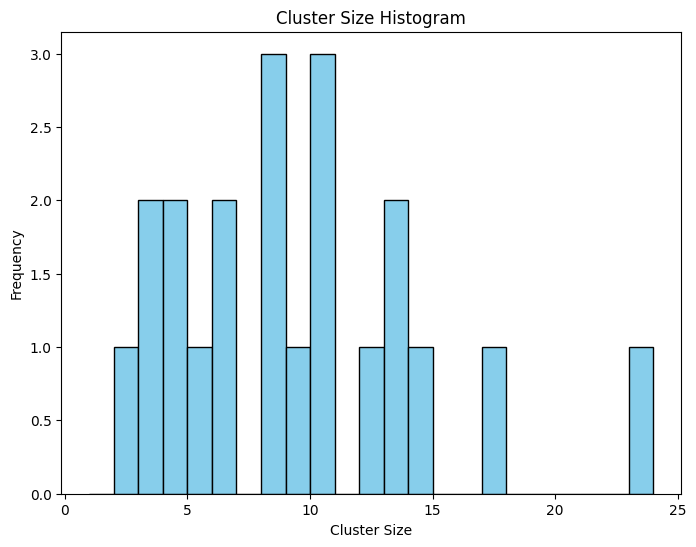

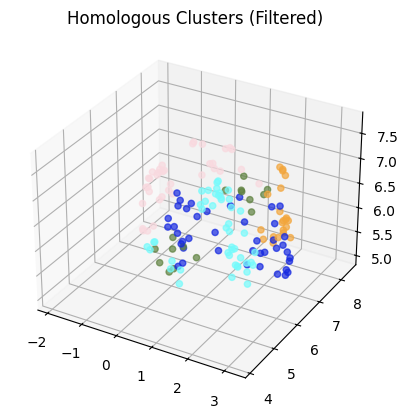

In [12]:
# Step 10: Run Clustering
print("\nRunning clustering on filtered dataset...")
labels, cluster_classes = cluster_embeddings(filtered_embeddings, filtered_predictions, distance_threshold)

## Build Genome-wise Feature Vectors, then a Feature Matrix

At this point, every protein belongs to a cluster, and every genome is represented by the set of clusters its proteins fall into. Here we transform that information into a **feature matrix**:

- **Rows = genomes**  
- **Columns = clusters**  
- **Values = how many proteins from that genome fall into each cluster**

This effectively gives each genome a **numerical fingerprint** based on its protein content.  

The function `construct_feature_vectors` builds this matrix, while `display_heatmap` shows it as a color-coded grid.  

Conceptually, we are moving from the “protein-level view” to the “genome-level view.” Each genome is now described not by raw sequences, but by its **distribution of functional protein clusters**. This matrix will later serve as the foundation for comparing genomes, building networks, and exploring relationships in the embedding space.


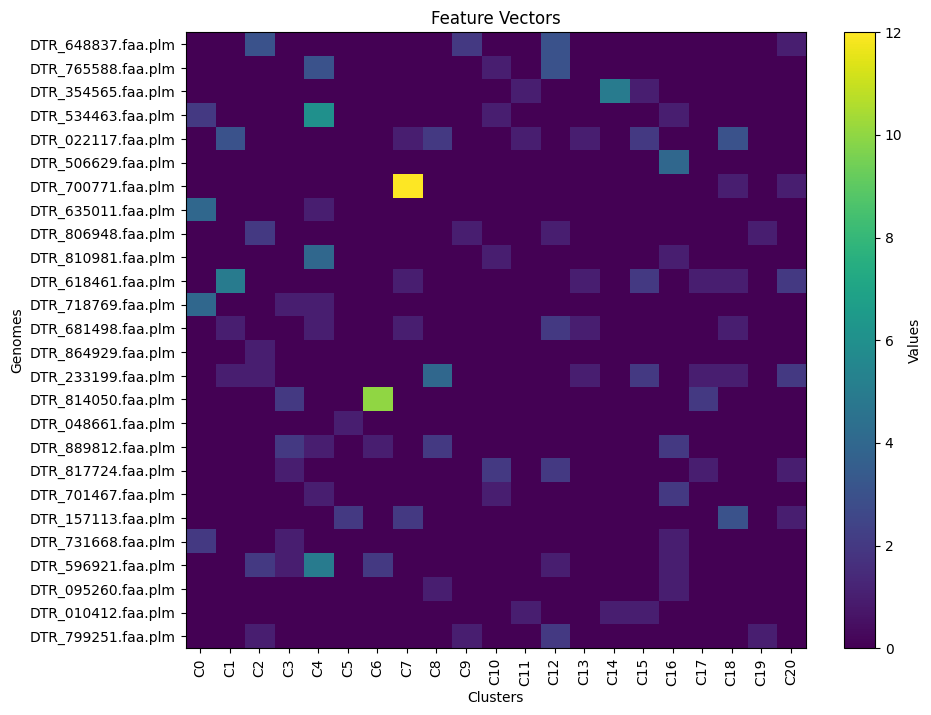

In [13]:
# Step 11: Build Feature Matrix
def display_heatmap(data, title, x_labels=None, y_labels=None):
    plt.figure(figsize=(10, 8))
    plt.imshow(data, cmap='viridis', aspect='auto')
    plt.colorbar(label='Values')
    plt.title(title)
    if x_labels: plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels, rotation=90)
    if y_labels: plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels)
    plt.xlabel('Clusters')
    plt.ylabel('Genomes')
    plt.show()

def construct_feature_vectors(embeddings_dict, clusters, protein_map):
    n_clusters = len(set(clusters))
    feature_matrix = {}
    for label, (genome, _) in zip(clusters, protein_map):
        feature_matrix.setdefault(genome, np.zeros(n_clusters))[label] += 1
    matrix = np.array(list(feature_matrix.values()))
    display_heatmap(matrix, title="Feature Vectors", y_labels=list(feature_matrix.keys()), x_labels=[f'C{i}' for i in range(n_clusters)])
    return feature_matrix

protein_map = [(g, p) for g, pdict in filtered_embeddings.items() for p in pdict]
features = construct_feature_vectors(filtered_embeddings, labels, protein_map)


## Interactive 3D Neighbors Genome Graph

Here we turn each genome’s **feature vector** (its counts across protein clusters) into a **directed k-nearest neighbor graph** and render it in **interactive 3D** with Plotly.

**What happens:**
- `build_knn_digraph(...)` stacks the feature vectors (one per genome), finds the **k nearest neighbors** of each genome using the chosen distance (`DISTANCE`), and builds a **directed edge** A → B if **B is among A’s k closest**.  
  - Directed means A → B doesn’t imply B → A; **mutual edges** highlight especially close pairs.
  - We default to **cosine distance** because our features are **compositional/count-like**; cosine emphasizes **pattern similarity** over absolute magnitude.
- `embed_3d(...)` projects the high-dimensional feature space into **3D coordinates** (UMAP/MDS/t-SNE/PCA). This is for visualization only; it does **not** affect which edges exist.
- `plot_3d_knn_graph(...)` draws:
  - **Nodes** (genomes) with **hover labels** (name and, if available, functional class).
  - **Edges** as line segments; optional **cones** indicate direction (source → target).
  - Optional **node colors** via `color_scheme` using your genome’s most prevalent class.

**Key controls (edit and re-run):**
- `K` — number of neighbors per genome (graph out-degree). Smaller K emphasizes the closest ties; larger K yields denser graphs.
- `DISTANCE` — `"cosine"` (good for relative composition) or `"euclidean"` (sensitive to magnitude).
- `EMBED` — `"UMAP"`, `"MDS"`, `"TSNE"`, or `"PCA"` for the 3D layout; try a few to see different neighborhood preservation.
- `ARROWS` — show/hide cone arrowheads to visualize direction.

**Interpretation:** clusters of nodes and many **mutual edges** suggest genomes with **similar protein cluster profiles** (i.e., similar functional composition). The 3D layout is for human inspection; the **graph structure** comes from distances in the original feature space.


In [15]:
# === Interactive 3D k-NN genome graph (directed) ===
# Requirements: features (dict[str, np.ndarray]) already defined
# Optional globals: color_scheme (dict[str->hex]), genome_functional_categories_filtered (dict[str->class])

!pip install -q plotly networkx

import numpy as np
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from umap import UMAP

# ---------- Helpers ----------
def build_knn_digraph(feature_dict, k=3, metric='cosine'):
    """Build a directed graph: for each genome, connect edges to its k nearest neighbors."""
    genomes = list(feature_dict.keys())
    if len(genomes) < 2:
        raise ValueError("Need at least 2 genomes to build a graph.")
    k = min(k, max(1, len(genomes) - 1))  # guard for small n

    X = np.vstack([np.asarray(feature_dict[g], dtype=float) for g in genomes])
    # Fit nearest neighbors (includes self as the closest neighbor)
    nbrs = NearestNeighbors(n_neighbors=k + 1, metric=metric)
    nbrs.fit(X)
    distances, indices = nbrs.kneighbors(X)

    G = nx.DiGraph()
    for i, g in enumerate(genomes):
        G.add_node(g, idx=i)

    for i, g in enumerate(genomes):
        # skip index 0 (self), keep next k as directed edges g -> neighbor
        for j_idx in indices[i][1:]:
            G.add_edge(g, genomes[j_idx])

    return G, genomes, X

def embed_3d(X, method='UMAP', metric='cosine', random_state=42):
    """3D embedding for visualization."""
    method = method.upper()
    if method == 'UMAP':
        reducer = UMAP(n_components=3, metric=metric, random_state=random_state)
        coords = reducer.fit_transform(X)
    elif method == 'MDS':
        # MDS needs distances
        D = pairwise_distances(X, metric=metric)
        from sklearn.manifold import MDS
        coords = MDS(n_components=3, dissimilarity='precomputed', random_state=random_state).fit_transform(D)
    elif method == 'TSNE':
        # t-SNE works better with precomputed distances for non-euclidean
        if metric == 'euclidean':
            from sklearn.manifold import TSNE
            coords = TSNE(n_components=3, init='random', learning_rate='auto',
                          random_state=random_state).fit_transform(X)
        else:
            D = pairwise_distances(X, metric=metric)
            from sklearn.manifold import TSNE
            coords = TSNE(n_components=3, metric='precomputed', init='random',
                          learning_rate='auto', random_state=random_state).fit_transform(D)
    else:
        # PCA fallback
        coords = PCA(n_components=3, random_state=random_state).fit_transform(X)
    return coords

def plot_3d_knn_graph(
    G, coords, genomes,
    node_meta=None,           # e.g., genome -> functional class
    color_scheme=None,        # e.g., class -> "#RRGGBB"
    show_cones=True,
    cone_scale=0.12,
    title="3D k-NN Genome Graph (k=3)"
):
    # map genome -> coord
    idx_map = {g: i for i, g in enumerate(genomes)}
    pos = {g: coords[idx_map[g]] for g in genomes}

    # Node colors
    if node_meta and color_scheme:
        node_colors = [color_scheme.get(str(node_meta.get(g, "unknown")).strip().lower(), "#808080") for g in genomes]
    else:
        node_colors = None

    # Node hover text
    if node_meta:
        hover_text = [f"{g}<br>class: {node_meta.get(g, 'unknown')}" for g in genomes]
    else:
        hover_text = [g for g in genomes]

    # Node scatter
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
    node_trace = go.Scatter3d(
        x=x, y=y, z=z,
        mode="markers",
        marker=dict(size=6, color=node_colors if node_colors else "#1f77b4"),
        text=hover_text,
        hovertemplate="%{text}<extra></extra>",
        name="Genomes"
    )

    # Edge segments
    edge_x, edge_y, edge_z = [], [], []
    for u, v in G.edges():
        x0, y0, z0 = pos[u]
        x1, y1, z1 = pos[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]
        edge_z += [z0, z1, None]
    edge_trace = go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        mode="lines",
        line=dict(width=2),
        hoverinfo="none",
        showlegend=False,
        name="Edges"
    )

    data = [edge_trace, node_trace]

    # Optional arrowheads via cones (direction u->v)
    if show_cones and len(G.edges()):
        cx, cy, cz, uu, vv, ww = [], [], [], [], [], []
        for u, v in G.edges():
            x0, y0, z0 = pos[u]
            x1, y1, z1 = pos[v]
            dx, dy, dz = (x1 - x0), (y1 - y0), (z1 - z0)
            # place cone near the target
            cx.append(x0 + 0.7 * dx)
            cy.append(y0 + 0.7 * dy)
            cz.append(z0 + 0.7 * dz)
            uu.append(dx)
            vv.append(dy)
            ww.append(dz)

        cone = go.Cone(
            x=cx, y=cy, z=cz, u=uu, v=vv, w=ww,
            sizemode="absolute", sizeref=cone_scale,
            showscale=False, anchor="tail",
            colorscale="Greys", name="Direction"
        )
        data = [edge_trace, cone, node_trace]

    fig = go.Figure(data=data)
    fig.update_layout(
        title=title,
        scene=dict(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False),
        showlegend=False,
        margin=dict(l=0, r=0, t=30, b=0),
        height=600
    )
    return fig

# ---------- Build & plot ----------
# Choose parameters
K = 2
DISTANCE = "cosine"     # 'cosine' is robust for count-like vectors; switch to 'euclidean' if you prefer
EMBED = "UMAP"          # 'UMAP', 'MDS', 'TSNE', 'PCA'
ARROWS = True           # draw 3D arrows via cones

G, genomes, X = build_knn_digraph(features, k=K, metric=DISTANCE)
coords = embed_3d(X, method=EMBED, metric=DISTANCE, random_state=42)

# Optional metadata for coloring/hover
node_meta = None
try:
    node_meta = genome_functional_categories_filtered
except NameError:
    pass

try:
    cs = color_scheme
except NameError:
    cs = None

fig = plot_3d_knn_graph(
    G, coords, genomes,
    node_meta=node_meta,
    color_scheme=cs,
    show_cones=ARROWS,
    cone_scale=0.12,
    title=f"3D {K}-NN Genome Graph ({DISTANCE}, {EMBED})"
)
fig.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## Final Note

The purpose of this workflow was to build an **embedding space** where all reference bacteriophage genomes could be mapped together. In this space, each genome is represented by its **distribution of protein clusters** learned from a protein language model. This turns the vast complexity of phage genomes into a navigable landscape, where distances correspond to similarity.

The long-term idea is that when we sequence **uncultured viruses**, we can project them into this same space. By observing the **density of reference genomes** in their local neighborhood, we can estimate **novelty**:  
- If a new genome lands in a crowded region, it likely belongs to a well-represented group.  
- If it lands in a sparse or empty region, it suggests unexplored diversity and potentially **novel biology**.  

This makes the embedding space not only a visualization tool but also a framework for discovery.

At the moment, we are working on a different project, but parts of this code will be repurposed. The core logic—building embeddings, clustering proteins, and constructing genome-level feature vectors—remains valuable.
